# 📊 Analyse de Performance - Modèle LSTM Sentinel2

**Mémoire - Système de Trading Algorithmique**

Modèle: LSTM Simple CLOSE ONLY (arXiv:2501.17366v1)

---

## Objectif
Analyser les performances du modèle LSTM en comparant les décisions prises avec les prix futurs réels.

In [3]:
# Imports
import sys
from pathlib import Path
import json
import warnings
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

# Ajouter le chemin src (chemin absolu depuis notebooks/)
NOTEBOOK_DIR = Path(__file__).parent if '__file__' in globals() else Path.cwd()
SRC_DIR = NOTEBOOK_DIR.parent
sys.path.insert(0, str(SRC_DIR))

from constants import CONSTANTS

print("✅ Imports réussis")
print(f"📊 Configuration LSTM: Séquence={CONSTANTS.LSTM_SEQUENCE_LENGTH}, Dropout={CONSTANTS.LSTM_DROPOUT_RATE}")

✅ Imports réussis
📊 Configuration LSTM: Séquence=216, Dropout=0.2


## 1️⃣ Chargement des Données

In [4]:
# Chemins des fichiers (chemins absolus depuis notebooks/)
NOTEBOOK_DIR = Path(__file__).parent if '__file__' in globals() else Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent.parent
DECISIONS_PATH = PROJECT_ROOT / "data/trading/decisions_log/trading_decisions.json"
PRICES_PATH = PROJECT_ROOT / "data/realtime/prices/spy_15min.parquet"

# Charger décisions
with open(DECISIONS_PATH, 'r') as f:
    decisions_data = json.load(f)

if isinstance(decisions_data, list):
    decisions = pd.DataFrame(decisions_data)
else:
    decisions = pd.DataFrame([decisions_data])

decisions['timestamp'] = pd.to_datetime(decisions['timestamp'])

# Charger prix
prices = pd.read_parquet(PRICES_PATH)

# Auto-détection colonne timestamp
time_candidates = ['timestamp', 'ts_utc', 'time', 'date', 'datetime']
time_col = next((col for col in time_candidates if col in prices.columns), None)
if time_col is None:
    print(f"⚠️ Colonnes disponibles dans prix: {list(prices.columns)}")
    time_col = prices.columns[0]
    print(f"   Utilisation de: {time_col}")

prices['timestamp'] = pd.to_datetime(prices[time_col])
prices = prices.sort_values('timestamp').reset_index(drop=True)

print(f"✅ {len(decisions)} décisions chargées")
print(f"✅ {len(prices)} prix chargés")
print(f"📅 Période décisions: {decisions['timestamp'].min()} → {decisions['timestamp'].max()}")
print(f"📅 Période prix: {prices['timestamp'].min()} → {prices['timestamp'].max()}")

✅ 9 décisions chargées
✅ 364 prix chargés
📅 Période décisions: 2025-10-02 17:09:46.758403+00:00 → 2025-10-02 19:45:11.810949+00:00
📅 Période prix: 2025-09-24 19:15:00+00:00 → 2025-10-03 07:30:00+00:00


In [5]:
# Aperçu des données
print("\n📋 Aperçu Décisions:")
display(decisions.head())

print("\n📋 Aperçu Prix:")
display(prices.head())


📋 Aperçu Décisions:


,ticker,timestamp,decision,confidence,fused_signal,current_price,signals,thresholds
0,SPY,2025-10-02 17:09:46.758403+00:00,HOLD,1.0,0.0,668.370,"{'price': 0.0, 'sentiment': 0.0, 'prediction':...","{'buy': 0.1, 'sell': -0.1, 'hold': 0.3}"
1,SPY,2025-10-02 17:30:07.381386+00:00,HOLD,1.0,0.0,668.590,"{'price': 0.0, 'sentiment': 0.0, 'prediction':...","{'buy': 0.1, 'sell': -0.1, 'hold': 0.3}"
2,SPY,2025-10-02 17:45:06.312375+00:00,HOLD,1.0,0.0,668.940,"{'price': 0.0, 'sentiment': 0.0, 'prediction':...","{'buy': 0.1, 'sell': -0.1, 'hold': 0.3}"
3,SPY,2025-10-02 18:00:08.179587+00:00,HOLD,1.0,0.0,668.900,"{'price': 0.0, 'sentiment': 0.0, 'prediction':...","{'buy': 0.1, 'sell': -0.1, 'hold': 0.3}"
4,SPY,2025-10-02 18:30:09.754012+00:00,HOLD,1.0,0.0,669.545,"{'price': 0.0, 'sentiment': 0.0, 'prediction':...","{'buy': 0.1, 'sell': -0.1, 'hold': 0.3}"



📋 Aperçu Prix:


,ticker,ts_utc,open,high,low,close,volume,timestamp
0,SPY,2025-09-24 19:15:00+00:00,660.65,660.90,660.5700,660.795,1397661.0,2025-09-24 19:15:00+00:00
1,SPY,2025-09-24 19:30:00+00:00,660.81,660.99,660.5900,660.645,2480595.0,2025-09-24 19:30:00+00:00
2,SPY,2025-09-24 19:45:00+00:00,660.65,661.38,660.4850,661.040,6604957.0,2025-09-24 19:45:00+00:00
3,SPY,2025-09-24 20:00:00+00:00,661.05,661.71,661.0500,661.690,4907982.0,2025-09-24 20:00:00+00:00
4,SPY,2025-09-24 20:15:00+00:00,661.70,661.74,661.4451,661.520,308764.0,2025-09-24 20:15:00+00:00


## 2️⃣ Calcul des Rendements Futurs

In [6]:
# Calculer rendements futurs (1 pas = 15 minutes)
HORIZON_STEPS = 1
prices['ret_next'] = prices['close'].pct_change(periods=HORIZON_STEPS).shift(-HORIZON_STEPS)

print(f"✅ Rendements futurs calculés (horizon={HORIZON_STEPS} pas)")
print(f"📊 Rendement moyen: {prices['ret_next'].mean()*100:.4f}%")
print(f"📊 Volatilité: {prices['ret_next'].std()*100:.4f}%")

✅ Rendements futurs calculés (horizon=1 pas)
📊 Rendement moyen: 0.0035%
📊 Volatilité: 0.0791%


## 3️⃣ Validation des Décisions

In [7]:
# Fusionner décisions avec prix
results = []
THRESHOLD_PCT = 0.001  # 0.1% seuil pour HOLD

for _, decision in decisions.iterrows():
    # Trouver prix le plus proche
    time_diff = abs(prices['timestamp'] - decision['timestamp'])
    closest_idx = time_diff.idxmin()
    closest_price = prices.iloc[closest_idx]
    
    # Ignorer si pas de rendement futur
    if pd.isna(closest_price['ret_next']):
        continue
    
    ret_next = closest_price['ret_next']
    decision_type = decision['decision']
    
    # Validation
    if decision_type == 'BUY':
        is_correct = ret_next > THRESHOLD_PCT
    elif decision_type == 'SELL':
        is_correct = ret_next < -THRESHOLD_PCT
    elif decision_type == 'HOLD':
        is_correct = abs(ret_next) <= THRESHOLD_PCT
    else:
        is_correct = False
    
    results.append({
        'timestamp': decision['timestamp'],
        'decision': decision_type,
        'confidence': decision.get('confidence', 0),
        'fused_signal': decision.get('fused_signal', 0),
        'close': closest_price['close'],
        'ret_next': ret_next,
        'ret_next_pct': ret_next * 100,
        'is_correct': is_correct
    })

results_df = pd.DataFrame(results)
print(f"✅ {len(results_df)} décisions validées")
display(results_df.head(10))

✅ 9 décisions validées


,timestamp,decision,confidence,fused_signal,close,ret_next,ret_next_pct,is_correct
0,2025-10-02 17:09:46.758403+00:00,HOLD,1.000000,0.000000,668.425,0.000247,0.024685,True
1,2025-10-02 17:30:07.381386+00:00,HOLD,1.000000,0.000000,668.590,0.000000,0.000000,True
2,2025-10-02 17:45:06.312375+00:00,HOLD,1.000000,0.000000,668.940,0.000000,0.000000,True
3,2025-10-02 18:00:08.179587+00:00,HOLD,1.000000,0.000000,668.900,0.000000,0.000000,True
4,2025-10-02 18:30:09.754012+00:00,HOLD,1.000000,0.000000,669.545,0.000000,0.000000,True
5,2025-10-02 18:45:06.378891+00:00,HOLD,1.000000,0.000000,669.455,0.000000,0.000000,True
6,2025-10-02 19:00:12.105419+00:00,HOLD,1.000000,0.000000,669.420,0.000000,0.000000,True
7,2025-10-02 19:30:06.367718+00:00,HOLD,0.998915,0.001085,669.551,-0.000577,-0.057651,True
8,2025-10-02 19:45:11.810949+00:00,HOLD,1.000000,0.000000,669.165,0.000000,0.000000,True


## 4️⃣ Métriques de Performance

In [8]:
# KPIs par type de décision
kpis = []

for decision_type in results_df['decision'].unique():
    subset = results_df[results_df['decision'] == decision_type]
    
    winning = subset[subset['is_correct']]
    losing = subset[~subset['is_correct']]
    
    kpis.append({
        'Décision': decision_type,
        'Total': len(subset),
        'Correct': len(winning),
        'Win Rate': f"{(len(winning)/len(subset)*100):.1f}%",
        'Ret Moyen': f"{subset['ret_next_pct'].mean():.3f}%",
        'Ret Médian': f"{subset['ret_next_pct'].median():.3f}%",
        'Volatilité': f"{subset['ret_next_pct'].std():.3f}%",
        'Confiance Moy': f"{subset['confidence'].mean():.3f}"
    })

# Total
kpis.append({
    'Décision': 'TOTAL',
    'Total': len(results_df),
    'Correct': len(results_df[results_df['is_correct']]),
    'Win Rate': f"{(results_df['is_correct'].mean()*100):.1f}%",
    'Ret Moyen': f"{results_df['ret_next_pct'].mean():.3f}%",
    'Ret Médian': f"{results_df['ret_next_pct'].median():.3f}%",
    'Volatilité': f"{results_df['ret_next_pct'].std():.3f}%",
    'Confiance Moy': f"{results_df['confidence'].mean():.3f}"
})

kpis_df = pd.DataFrame(kpis)
print("\n📊 MÉTRIQUES DE PERFORMANCE")
print("="*80)
display(kpis_df.style.set_properties(**{'text-align': 'center'}).set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]}]
))


📊 MÉTRIQUES DE PERFORMANCE


,Décision,Total,Correct,Win Rate,Ret Moyen,Ret Médian,Volatilité,Confiance Moy
0,HOLD,9,9,100.0%,-0.004%,0.000%,0.022%,1.000
1,TOTAL,9,9,100.0%,-0.004%,0.000%,0.022%,1.000


## 5️⃣ Visualisations

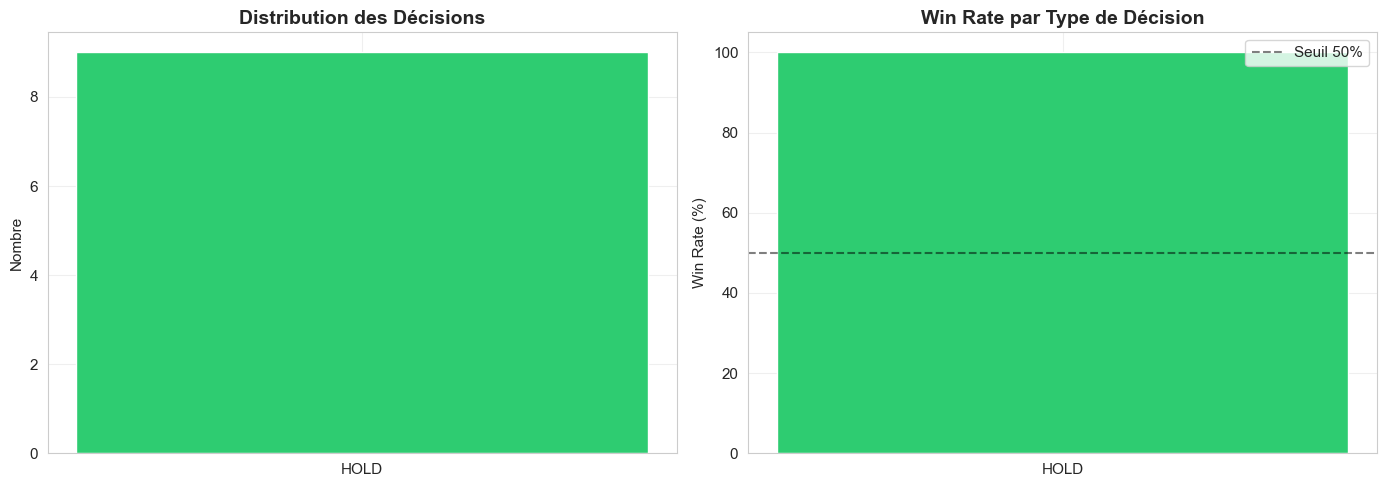

✅ Graphique sauvegardé: performance_overview.png


In [9]:
# Graphique 1: Distribution des décisions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution par type
decision_counts = results_df['decision'].value_counts()
axes[0].bar(decision_counts.index, decision_counts.values, color=['#2ecc71', '#e74c3c', '#3498db'])
axes[0].set_title('Distribution des Décisions', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Nombre')
axes[0].grid(alpha=0.3)

# Win Rate par type
win_rates = results_df.groupby('decision')['is_correct'].mean() * 100
colors = ['#2ecc71' if x > 50 else '#e74c3c' for x in win_rates.values]
axes[1].bar(win_rates.index, win_rates.values, color=colors)
axes[1].axhline(y=50, color='black', linestyle='--', alpha=0.5, label='Seuil 50%')
axes[1].set_title('Win Rate par Type de Décision', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Win Rate (%)')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('performance_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Graphique sauvegardé: performance_overview.png")

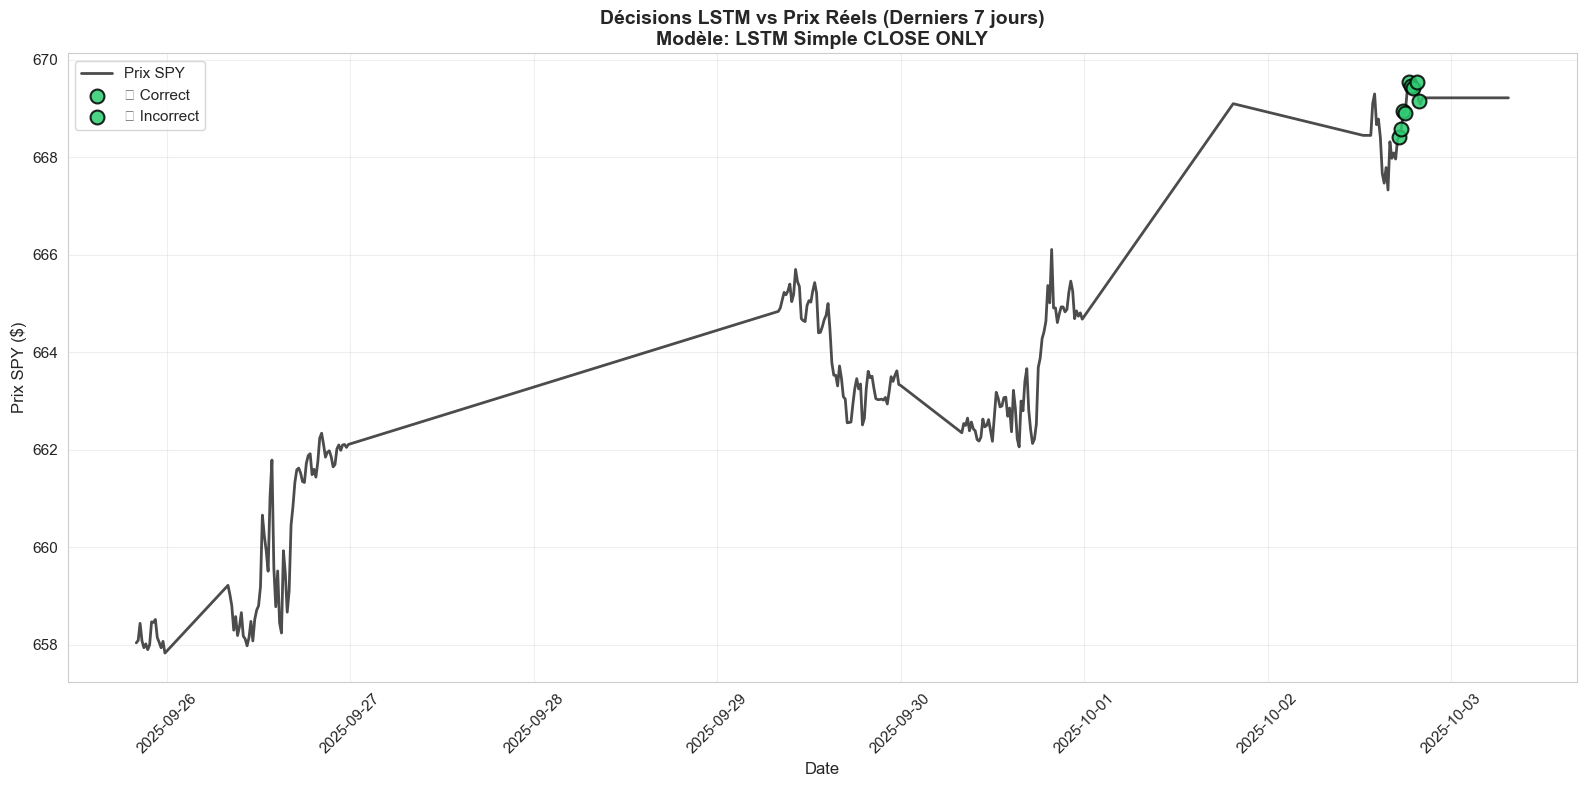

✅ Graphique sauvegardé: decisions_vs_price.png


In [10]:
# Graphique 2: Décisions vs Prix (derniers 7 jours)
window_days = 7
cutoff = results_df['timestamp'].max() - timedelta(days=window_days)
recent_results = results_df[results_df['timestamp'] >= cutoff]
recent_prices = prices[prices['timestamp'] >= cutoff]

fig, ax = plt.subplots(figsize=(16, 8))

# Prix
ax.plot(recent_prices['timestamp'], recent_prices['close'], 'k-', linewidth=2, label='Prix SPY', alpha=0.7)

# Décisions
markers = {'BUY': '^', 'SELL': 'v', 'HOLD': 'o'}
sizes = {'BUY': 200, 'SELL': 200, 'HOLD': 100}

for _, row in recent_results.iterrows():
    color = '#2ecc71' if row['is_correct'] else '#e74c3c'
    ax.scatter(row['timestamp'], row['close'], 
               marker=markers[row['decision']], 
               s=sizes[row['decision']], 
               c=color, edgecolors='black', linewidth=1.5, alpha=0.85, zorder=3)

ax.set_title(f'Décisions LSTM vs Prix Réels (Derniers {window_days} jours)\nModèle: LSTM Simple CLOSE ONLY', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Prix SPY ($)', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(['Prix SPY', '✓ Correct', '✗ Incorrect'], loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('decisions_vs_price.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Graphique sauvegardé: decisions_vs_price.png")

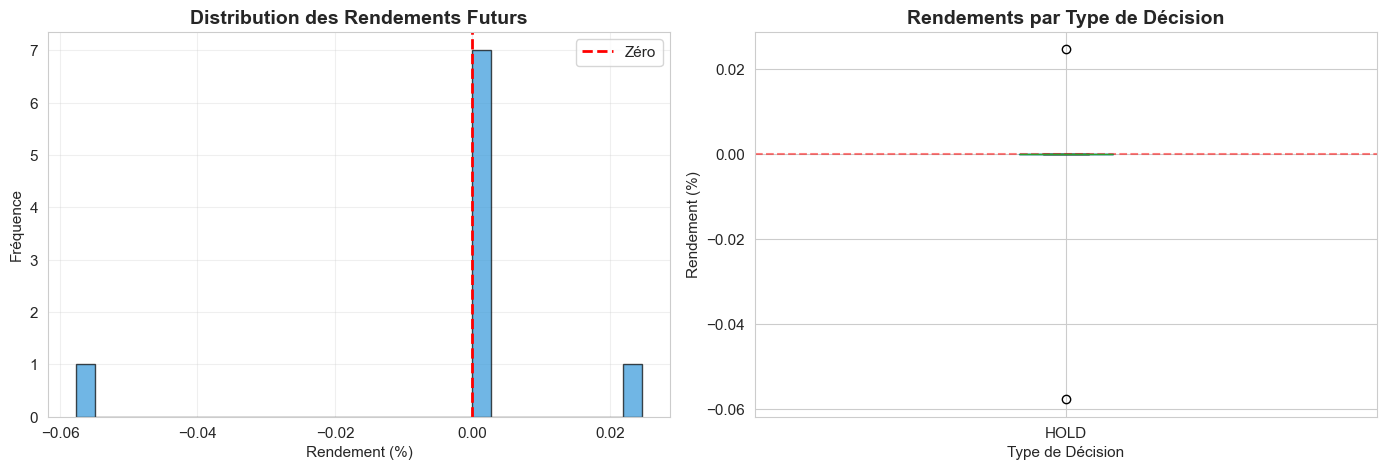

✅ Graphique sauvegardé: returns_distribution.png


In [11]:
# Graphique 3: Distribution des rendements
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme
axes[0].hist(results_df['ret_next_pct'], bins=30, color='#3498db', alpha=0.7, edgecolor='black')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zéro')
axes[0].set_title('Distribution des Rendements Futurs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Rendement (%)')
axes[0].set_ylabel('Fréquence')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Boxplot par décision
results_df.boxplot(column='ret_next_pct', by='decision', ax=axes[1])
axes[1].set_title('Rendements par Type de Décision', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Type de Décision')
axes[1].set_ylabel('Rendement (%)')
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
plt.suptitle('')  # Supprimer titre auto

plt.tight_layout()
plt.savefig('returns_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Graphique sauvegardé: returns_distribution.png")

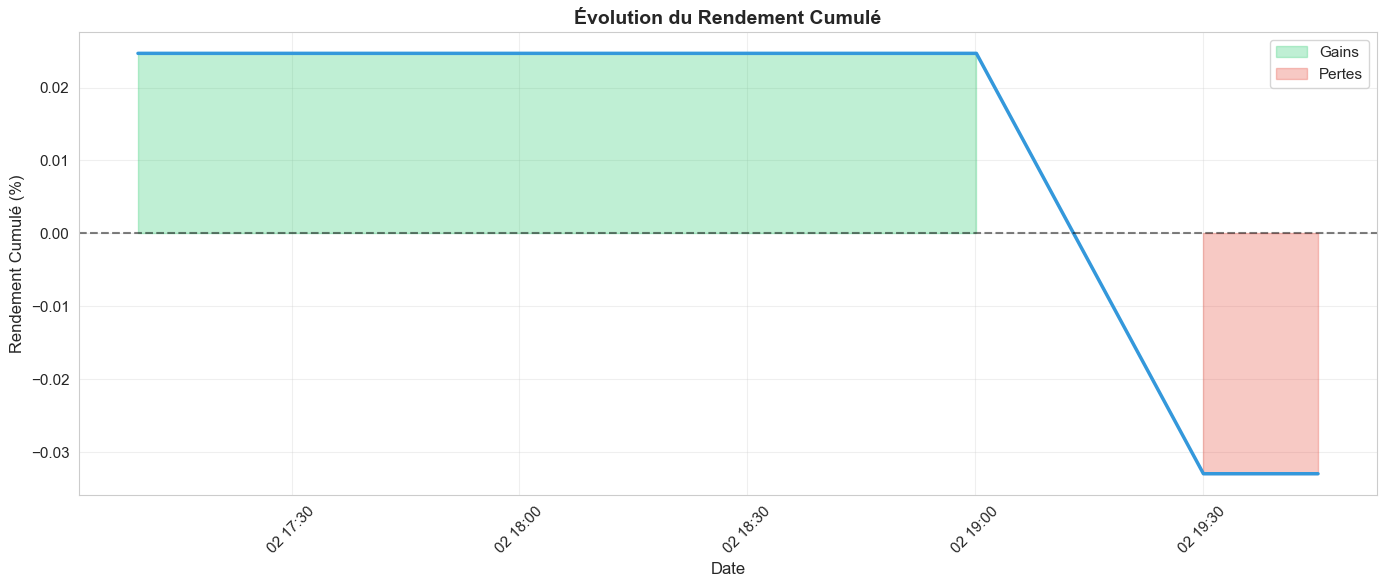

✅ Graphique sauvegardé: cumulative_return.png


In [12]:
# Graphique 4: Rendement cumulé
results_sorted = results_df.sort_values('timestamp')
cumulative_return = (1 + results_sorted['ret_next']).cumprod() - 1

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(results_sorted['timestamp'], cumulative_return * 100, linewidth=2.5, color='#3498db')
ax.fill_between(results_sorted['timestamp'], 0, cumulative_return * 100, 
                 where=(cumulative_return >= 0), color='#2ecc71', alpha=0.3, label='Gains')
ax.fill_between(results_sorted['timestamp'], 0, cumulative_return * 100, 
                 where=(cumulative_return < 0), color='#e74c3c', alpha=0.3, label='Pertes')
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.set_title('Évolution du Rendement Cumulé', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Rendement Cumulé (%)', fontsize=12)
ax.legend()
ax.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('cumulative_return.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Graphique sauvegardé: cumulative_return.png")

## 6️⃣ Export des Résultats

In [13]:
# Sauvegarder tableaux pour mémoire
kpis_df.to_csv('performance_metrics.csv', index=False)
results_df.to_csv('validation_results.csv', index=False)

print("✅ Fichiers exportés:")
print("   - performance_metrics.csv")
print("   - validation_results.csv")
print("   - performance_overview.png")
print("   - decisions_vs_price.png")
print("   - returns_distribution.png")
print("   - cumulative_return.png")

✅ Fichiers exportés:
   - performance_metrics.csv
   - validation_results.csv
   - performance_overview.png
   - decisions_vs_price.png
   - returns_distribution.png
   - cumulative_return.png


## 7️⃣ Résumé

In [15]:
# Générer résumé
total_decisions = len(results_df)
win_rate = results_df['is_correct'].mean() * 100
avg_return = results_df['ret_next_pct'].mean()
total_return = cumulative_return.iloc[-1] * 100
sharpe = (results_df['ret_next'].mean() / results_df['ret_next'].std()) if results_df['ret_next'].std() > 0 else 0

print("\n" + "="*80)
print("📊 RÉSUMÉ")
print("="*80)
print(f"\n🎯 MODÈLE: LSTM Simple CLOSE ONLY")
print(f"   - Séquence: {CONSTANTS.LSTM_SEQUENCE_LENGTH} jours")
print(f"   - Architecture: 2 couches LSTM (64 units)")
print(f"   - Dropout: {CONSTANTS.LSTM_DROPOUT_RATE}")
print(f"\n📈 PERFORMANCES:")
print(f"   - Décisions analysées: {total_decisions}")
print(f"   - Win Rate: {win_rate:.1f}%")
print(f"   - Rendement moyen: {avg_return:+.3f}%")
print(f"   - Rendement cumulé: {total_return:+.2f}%")
print(f"   - Sharpe Ratio: {sharpe:.3f}")
print(f"\n📊 PAR TYPE:")
for _, row in kpis_df[kpis_df['Décision'] != 'TOTAL'].iterrows():
    print(f"   - {row['Décision']:>4}: {row['Total']} décisions, Win Rate {row['Win Rate']}")
print("\n" + "="*80)


📊 RÉSUMÉ

🎯 MODÈLE: LSTM Simple CLOSE ONLY
   - Séquence: 216 jours
   - Architecture: 2 couches LSTM (64 units)
   - Dropout: 0.2

📈 PERFORMANCES:
   - Décisions analysées: 9
   - Win Rate: 100.0%
   - Rendement moyen: -0.004%
   - Rendement cumulé: -0.03%
   - Sharpe Ratio: -0.168

📊 PAR TYPE:
   - HOLD: 9 décisions, Win Rate 100.0%

